# Equação de Conservação Hiperbólica 1D

Vamos resolver numericamente equações de conservação hiperbólica a 1D:

\begin{align*}

\frac{\partial u}{\partial t} + \frac{\partial f(u)}{\partial x} = 0

\end{align*}

# Imports

In [1]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método Richtmyer

In [2]:
def cons1DRichtmyer(T: float, ui: np.ndarray, mask: np.ndarray, ff: Callable[[np.ndarray], np.ndarray], dx: float, dt: float, periodic: bool = False, save: bool = False) -> tuple[np.ndarray, float]:
    """
        Resolve uma equação de conservação hiperbólica 1D com o método de Richtmyer!

        :param T: float, Tempo para evoluir a equação
        :param ui: np.ndarray, array com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True` e usa `mask[0]`/ `mask[-1]` para determinar se os extremos esquerdo/ direito são fechados (caso `False`) ou abertos (caso `True`)
        :param ff: np.ndarray, função de fluxo
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dt: float, espaçamento entre pontos no eixo dos tt
        :param periodic: bool, se for `True` usamos condição fronteira periódicas
        :param save: bool, se for `True` guardamos o estado em todos os frames

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    now = np.copy(ui)
    nex = np.copy(ui)

    total = []
    if save:
        total = [list(np.copy(ui))]

    # Condições de extremo aberto
    openL = mask[0]
    openR = mask[-1]

    # Criar o passo no tempo
    iMax = T // dt + 1

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Arrays para condição de fronteira periódicas
        left = np.concatenate((now[-1:], now[:-1]))
        righ = np.concatenate((now[1:], now[0:1]))
        
        # Alterar para condição extremo aberto
        if not periodic:
            if openL:
                left[0] = now[1]
            if openR:
                righ[-1] = now[-2]
        

        # Passo predictor
        lpred = (now + left) / 2 - (dt / (2 * dx)) * (ff(now) - ff(left))
        rpred = (righ + now) / 2 - (dt / (2 * dx)) * (ff(righ) - ff(now))

        # Passo corrector
        nex = now - mask * ((dt / dx) * (ff(rpred) - ff(lpred)))

        
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)

        if save:
            total += [list(np.copy(now))]
    
    # Devolver todos os estados
    if save:
        return np.array(total), dt
    
    return now, i * dt

# Método MacCormack

In [3]:
def cons1DMac(T: float, ui: np.ndarray, mask: np.ndarray, ff: Callable[[np.ndarray], np.ndarray], dx: float, dt: float, periodic: bool = False, save: bool = False) -> tuple[np.ndarray, float]:
    """
        Resolve uma equação de conservação hiperbólica 1D com o método de MacCormack!

        :param T: float, Tempo para evoluir a equação
        :param ui: np.ndarray, array com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True` e usa `mask[0]`/ `mask[-1]` para determinar se os extremos esquerdo/ direito são fechados (caso `False`) ou abertos (caso `True`)
        :param ff: np.ndarray, função de fluxo
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dt: float, espaçamento entre pontos no eixo dos tt
        :param periodic: bool, se for `True` usamos condição fronteira periódicas
        :param save: bool, se for `True` guardamos o estado em todos os frames

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    now = np.copy(ui)
    nex = np.copy(ui)

    total = []
    if save:
        total = [list(np.copy(ui))]

    # Condições de extremo aberto
    openL = mask[0]
    openR = mask[-1]

    # Criar o passo no tempo
    iMax = T // dt + 1

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Arrays para condição de fronteira periódicas
        left = np.concatenate((now[-1:], now[:-1]))
        righ = np.concatenate((now[1:], now[0:1]))
        
        # Alterar para condição extremo aberto
        if not periodic:
            if openL:
                left[0] = now[1]
            if openR:
                righ[-1] = now[-2]
        

        # Passo predictor
        lpred = left - (dt / dx) * (ff(now) - ff(left))
        rpred = now - (dt / dx) * (ff(righ) - ff(now))

        # Passo corrector
        nex = now + mask * ((now + rpred) / 2 - (dt / (2 * dx)) * (ff(rpred) - ff(lpred)) - now)

        
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)

        if save:
            total += [list(np.copy(now))]
    
    # Devolver todos os estados
    if save:
        return np.array(total), dt
    
    return now, i * dt

# Testar

## Caso 1 - Advecção

In [4]:
# Parâmetros
v = 1

Lx = 50
Nx = 900
dx = Lx / (Nx - 1)

Tmax = 15
C = 1
dt = C * dx / v

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira extremo constante
mask = np.full_like(xx, True)
mask[0] = False
mask[-1] = False


# Função fluxo
def fluxo(u: np.ndarray) -> np.ndarray:
    return v * u

# Condição inicial
df = Lx/3
def u0(x):
    return np.exp(-(x+df)**2)

ui = u0(xx)

### Método Richtmyer

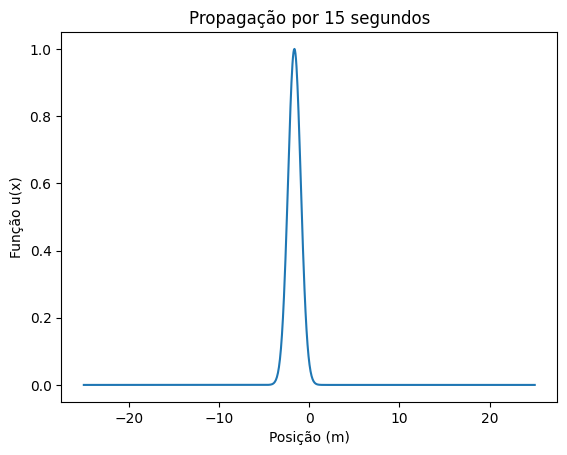

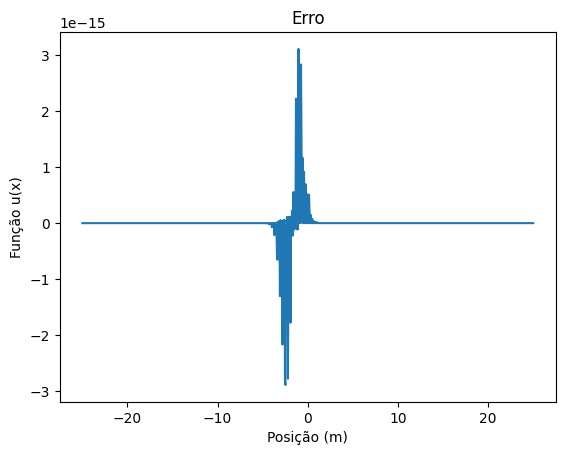

MovieWriter ffmpeg unavailable; using Pillow instead.


In [5]:
# Fazer a simulação
sol, dt = cons1DRichtmyer(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - u0(xx - v * dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 8

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT1-01.gif', writer='ffmpeg', fps=20)
plt.close()

### Método MacCormack

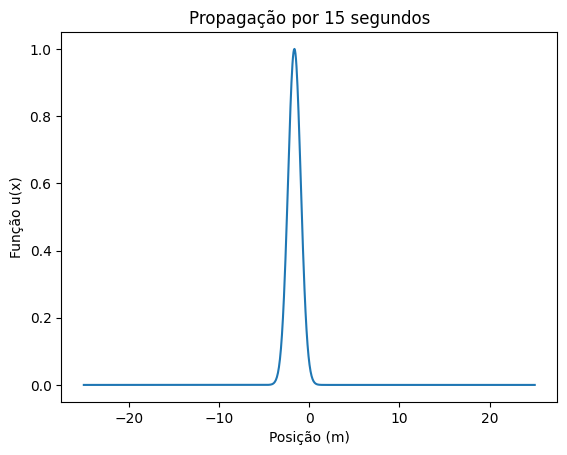

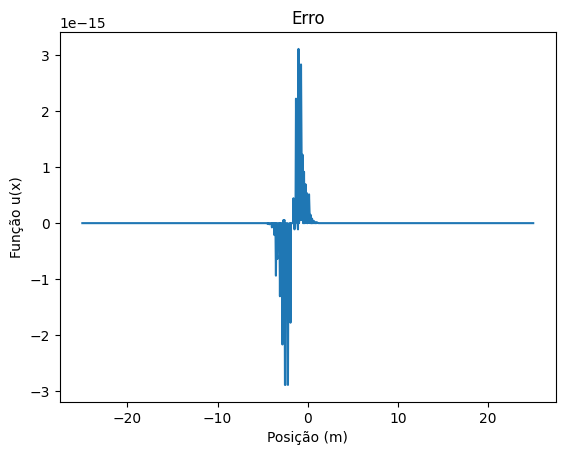

MovieWriter ffmpeg unavailable; using Pillow instead.


In [6]:
# Fazer a simulação
sol, dt = cons1DMac(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - u0(xx - v * dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 8

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT1-02.gif', writer='ffmpeg', fps=20)
plt.close()

## Caso 2 - Equação de Burgers Ivíscida

In [7]:
# Parâmetros
Lx = 1
Nx = 1500
dx = Lx / (Nx - 1)

Tmax = 1
dt = dx

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira extremo fixo à esquerda e aberto à direita
mask = np.full_like(xx, True)
mask[0] = False
mask[-1] = True


# Função fluxo
def fluxo(u: np.ndarray) -> np.ndarray:
    return u ** 2 / 2

# Condição inicial
a = 0.8
def u0(x: np.ndarray) -> np.ndarray:
    ret = np.zeros_like(x)
    ret[:ret.shape[0]//2] = a
    return ret

ui = u0(xx)

### Método Richtmyer

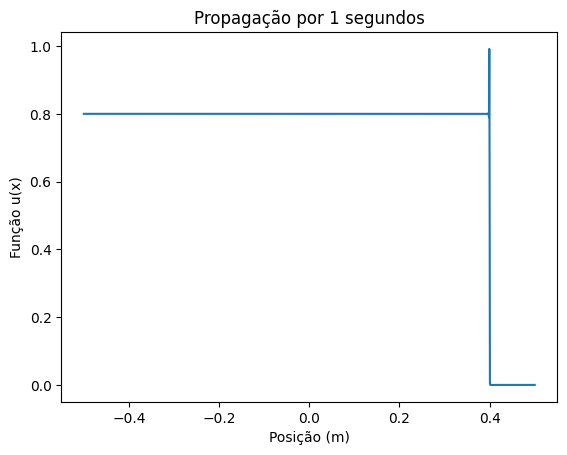

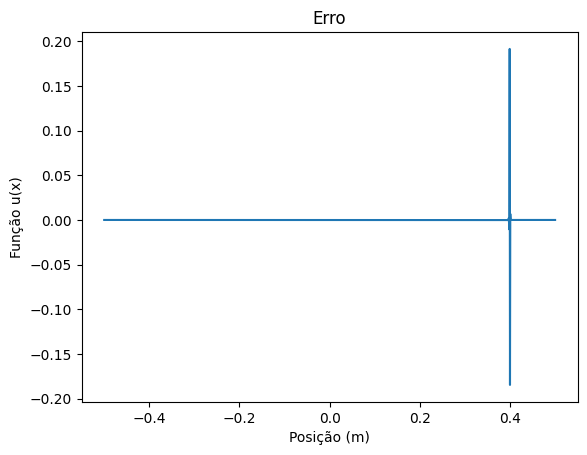

MovieWriter ffmpeg unavailable; using Pillow instead.


In [8]:
# Fazer a simulação
sol, dt = cons1DRichtmyer(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - a * ((xx - a/2 * dt * (len(sol) - 1)) < 0), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 20

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT2-01.gif', writer='ffmpeg', fps=20)
plt.close()

### Método MacCormack

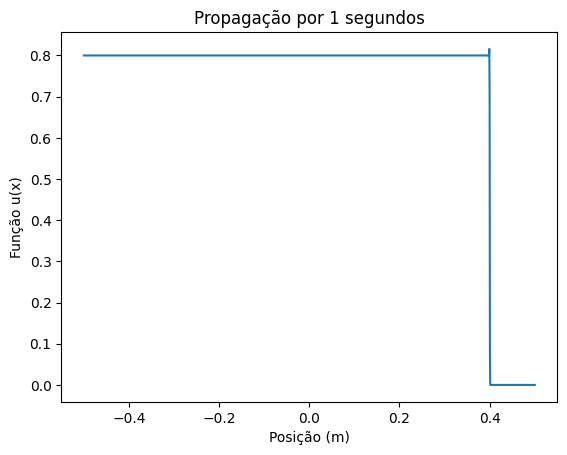

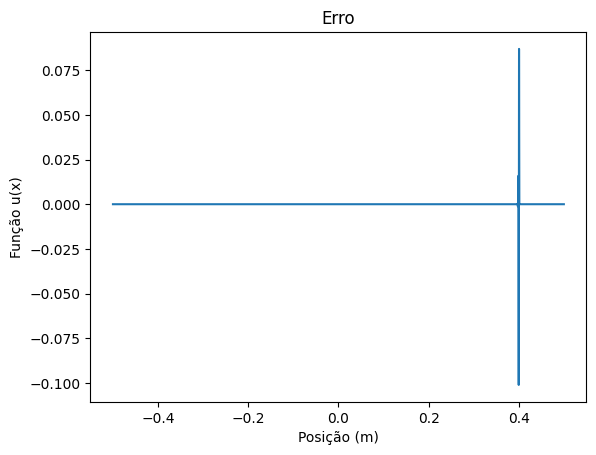

MovieWriter ffmpeg unavailable; using Pillow instead.


In [9]:
# Fazer a simulação
sol, dt = cons1DMac(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - a * ((xx - a/2 * dt * (len(sol) - 1)) < 0), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 20

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT2-02.gif', writer='ffmpeg', fps=20)
plt.close()

## Caso 3 - Equação de Burgers Víscida

In [10]:
# Parâmetros
Lx = 1
Nx = 1000
dx = Lx / (Nx - 1)

Tmax = 1
dt = 0.01 * dx

sigma = 1e-3

# Domínio
xx = np.linspace(-Lx/2, Lx/2, Nx)

# Condições fronteira extremo constante
mask = np.full_like(xx, True)
mask[0] = False
mask[1] = False
mask[-1] = False
mask[-2] = False


# Função fluxo
def derivada(x: np.ndarray) -> np.ndarray:
    meio = (x[2:] - x[:-2]) / (2 * dx)
    left = (x[1] - x[0]) / dx
    righ = (x[-1] - x[-2]) / dx

    return np.array([left] + list(meio) + [righ])


def fluxo(u: np.ndarray) -> np.ndarray:
    return u ** 2 / 2 - sigma * derivada(u)


# Condição inicial
a = 1
def u0(x: np.ndarray) -> np.ndarray:
    ret = np.zeros_like(x)
    ret[:ret.shape[0]//2] = a
    return ret

ui = u0(xx)


# Solução analítica
# Está na página 16 do seguitne PDF:
# https://www.iist.ac.in/sites/default/files/people/IN08026/Burgers_equation_viscous.pdf 
def solAnal(x: np.ndarray, t: float) -> np.ndarray:
    ul = a
    ur = 0
    s = (ul + ur) / 2
    return ul - (ul - ur) / (1 + (sp.special.erfc((x - ur * t) / np.sqrt(4 * sigma * t)) / sp.special.erfc((x - ul * t) / np.sqrt(4 * sigma * t))) * np.exp(-(ul - ur) * (x - s * t) / (2 * sigma)))

### Método Richtmyer

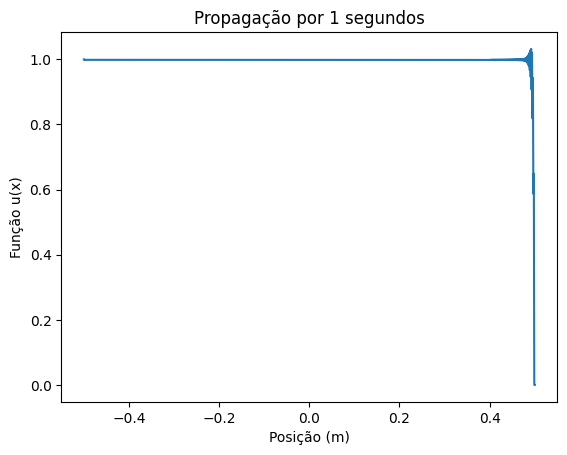

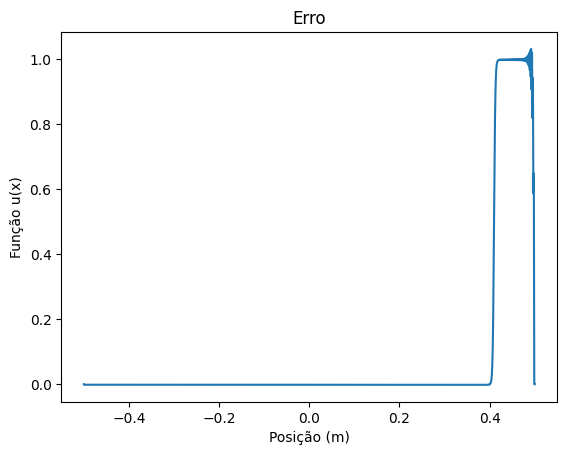

MovieWriter ffmpeg unavailable; using Pillow instead.


In [11]:
# Fazer a simulação
sol, dt = cons1DRichtmyer(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - solAnal(xx, dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 1500

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT3-01.gif', writer='ffmpeg', fps=20)
plt.close()

### Método MacCormack

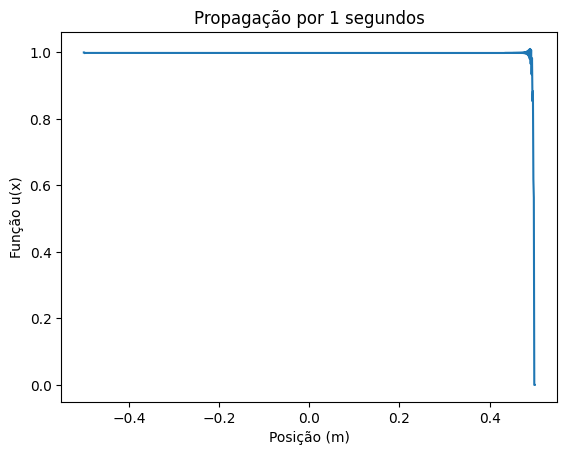

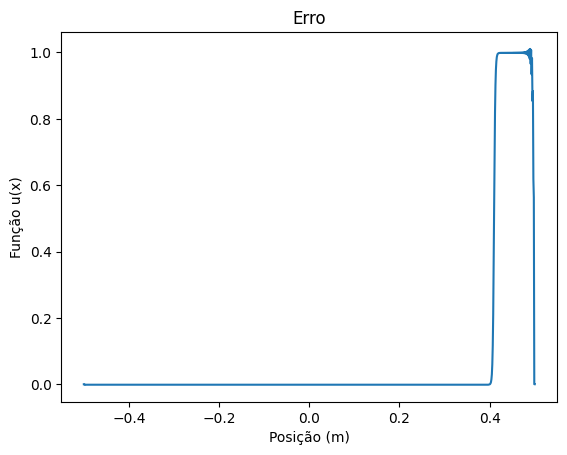

MovieWriter ffmpeg unavailable; using Pillow instead.


In [12]:
# Fazer a simulação
sol, dt = cons1DMac(Tmax, ui, mask, fluxo, dx, dt, save=True)

# Mostrar a solução
plt.plot(xx, sol[-1], label="Resultado")
plt.title(f"Propagação por {dt * (len(sol) - 1):.0f} segundos")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()

# Comparar com a solução exata
plt.plot(xx, sol[-1] - solAnal(xx, dt * (len(sol) - 1)), label="Resultado")
plt.title(f"Erro")
plt.xlabel('Posição (m)')
plt.ylabel('Função u(x)')
plt.show()


# Inicializar o Vídeo!
fig, ax = plt.subplots()
line, = ax.plot(xx, sol[0])
ax.set_ylim(-0.04, 1.04)


# Velocidade
videoS = 1500

# Função de inicialização
def init():
    plt.title(f"Propagação por 0 segundos")
    plt.xlabel('Posição (m)')
    plt.ylabel('Função u(x)')
    line.set_ydata(sol[0])
    return line,

# Função de atualização
def update(frame):
    index =  frame * videoS

    plt.title(f"Propagação por {dt * index:.2f} segundos")
    line.set_ydata(sol[index])
    return line,

# Criar a animação
ani = animation.FuncAnimation(fig, update, frames=np.arange(0, len(sol) // videoS), init_func=init, blit=True, interval=50)
ani.save('animationT3-02.gif', writer='ffmpeg', fps=20)
plt.close()